## Forecasting Bitcoin Prices with Time Series

### Natália Faraj Murad

   The goal here is to predict bitcoin prices using time series models. The bitcoin data was downloaded using the Yahoo Finance API. Data were explored and processed to be ready as input to the models. Four models were adjusted and evaluated: Naive Bayes, ARIMA, SARIMAX and Prophet. All of them presented a good result, unless Naive Bayes. The models were created considering a daily period.

In [46]:
# Silence warnings
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Data Manipulation
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from scipy.special import boxcox, inv_boxcox

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Data Source
import yfinance as yf

# Stats models
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import statsmodels.api as sm

# Date tools
from datetime import datetime, timedelta, date


import prophet
from prophet import Prophet

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import jarque_bera
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Graphic params
plt.rcParams["figure.figsize"] = (14,6)
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

## Load the data

Using Yahoo Finance API to get the Bitcoin Prices Data.

In [2]:
data = yf.download(tickers='BTC-USD', start = '2015-01-01', end = date.today(), interval = '1D')

[*********************100%***********************]  1 of 1 completed


Setting Date as index.

In [3]:
dataClose = data['Close'].reset_index()
dataCloseSerie = dataClose.set_index('Date')

In [4]:
# Data Visualization
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


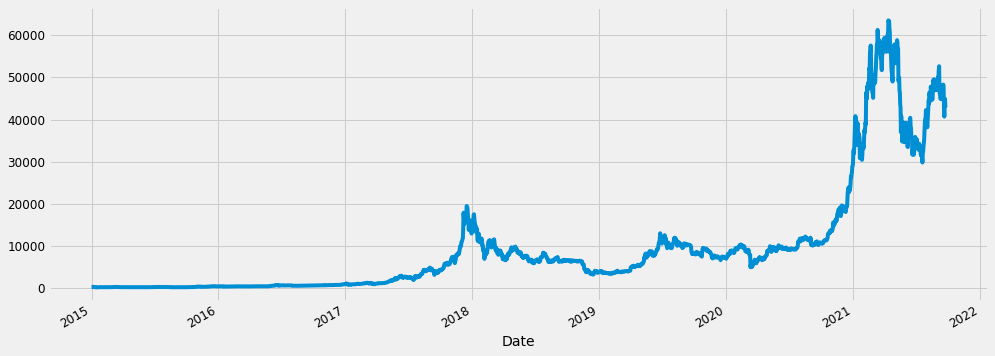

In [5]:
# Plot temporal serie
data.Close.plot(figsize = (15, 6))
plt.show()

## Stationarity

In [6]:
# Defining a function to test serie stationarity.
def stationarity_test(serie):
    
    # Calculate mobile stats
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot mobile stats
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Mobile Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Mobile Stats - Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller Test:
    # Print
    print('\nDickey-Fuller Test Result:\n')

    # Test
    dftest = adfuller(serie, autolag = 'AIC')

    # Output
    dfout= pd.Series(dftest[0:4], index = ['Test Stats',
                                               'p-value',
                                               'Number of Lags',
                                               'Number of Used Observations'])

    # Loop for each test output
    for key, value in dftest[4].items():
        dfout['Critic Value (%s)'%key] = value

    # Print
    print (dfout)
    
    # Test p-value
    print ('\nConclusion:')
    if dfout[1] > 0.05:
        print('\nO p-valuer > 0.05 and, therefore, we have no evidences to reject H0.')
        print('This serie probably is not stationary.')
    else:
        print('\nO p-value < 0.05 and, therefore, we have evidences to reject H0.')
        print('This serie probably is stationary')

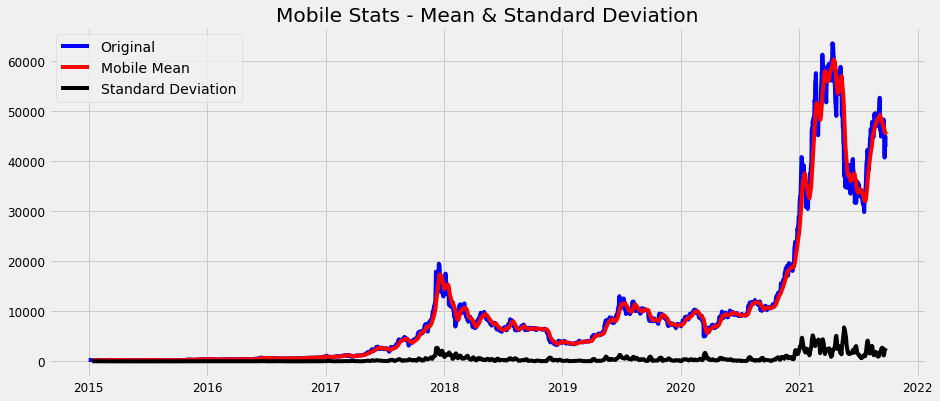


Dickey-Fuller Test Result:

Test Stats                       -0.593931
p-value                           0.872347
Number of Lags                   27.000000
Number of Used Observations    2428.000000
Critic Value (1%)                -3.433046
Critic Value (5%)                -2.862731
Critic Value (10%)               -2.567404
dtype: float64

Conclusion:

O p-valuer > 0.05 and, therefore, we have no evidences to reject H0.
This serie probably is not stationary.


In [7]:
# Apply function
stationarity_test(data['Close'])

The serie must be stationary to be passed to the model. A serie is stationary when its properties like mean and variance remain constant over time. This series will be differentiated in order to get stationary.

## Decomposition

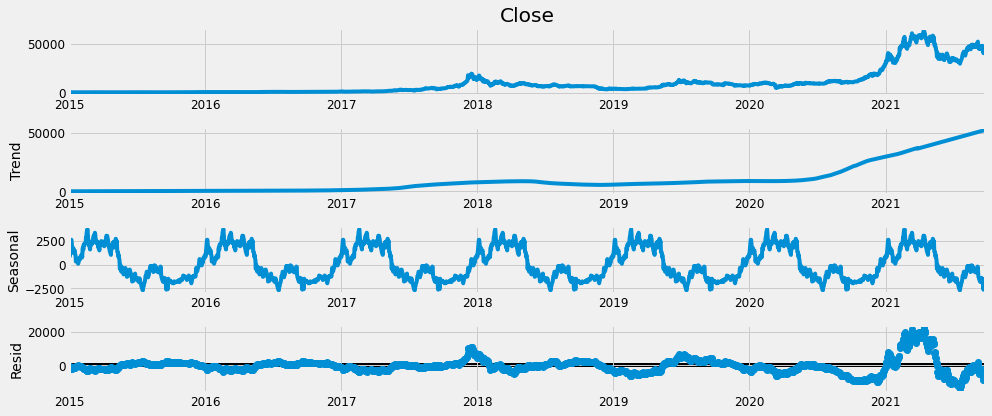

In [8]:
# Decompose - Addictive
result_add = seasonal_decompose(data['Close'], model = 'additive', period=365, extrapolate_trend = 'freq')

# Plot
result_add.plot()
plt.show()

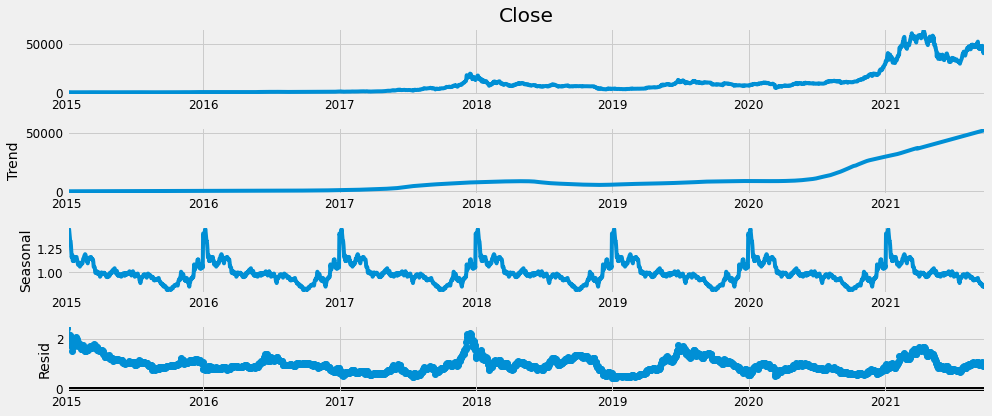

In [9]:
# Decompose - Multuplicative 
result_mul = seasonal_decompose(data['Close'], model = 'multiplicative', period = 365, extrapolate_trend = 'freq')

# Plot
result_mul.plot()
plt.show()

In [10]:
# Extracting Components
# Observations = (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstructed.columns = ['Seasonal', 'Trend', 'Resid', 'Observed_Values']
df_reconstructed.head()

,Seasonal,Trend,Resid,Observed_Values
Date,,,,
2015-01-01,1.418542,91.147847,2.430443,314.248993
2015-01-02,1.407117,91.980494,2.434047,315.032013
2015-01-03,1.382823,92.813141,2.190064,281.082001
2015-01-04,1.375800,93.645789,2.050600,264.195007
2015-01-05,1.421053,94.478436,2.044365,274.473999


This serie presents a trend of increasing since 2020. It also have a annual seasonal component and random residuals.

## Autocorrelation

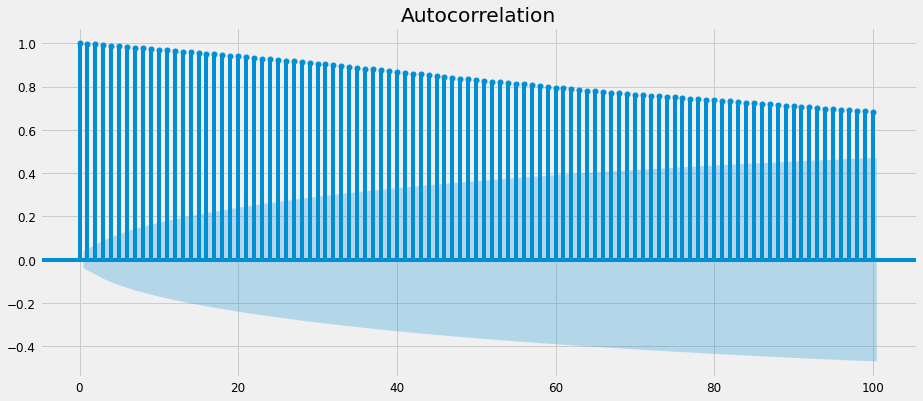

In [11]:
# Plot ACF (Auto Correlation)
acf_plot = plot_acf(data.Close, lags = 100)

This serie is strongly autocorrelated.

## Box Cox Transformation

Using Box Transformation in the serie because the series does not have constant variance.

In [12]:
data['Close_Box'], lmbda = stats.boxcox(data.Close)

## Differentiation

Defining functions to differenciate the serie to transform it in stationary and a function to get the real values back later.

In [14]:
# Differentiation function
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


# invert differenced value
def inverse_difference(history, yhat):
    desdiff = list()
    for i in range(1, len(yhat)):
        valued = yhat[i] + history[i-1]
        desdiff.append(valued)
    return desdiff

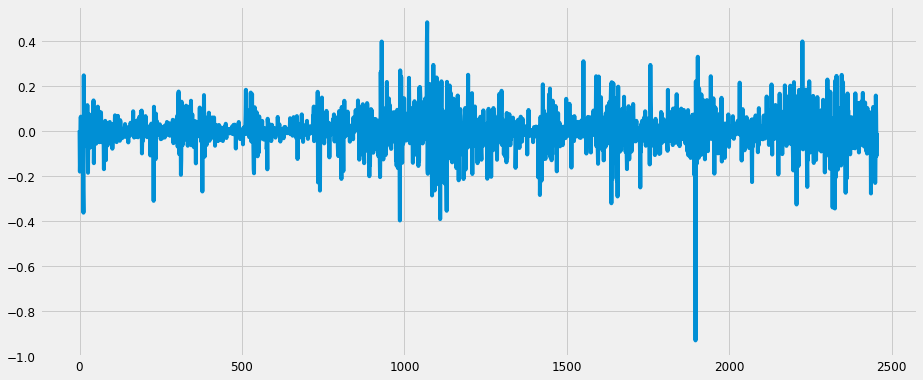

In [15]:
# Differentiation of 1st order
cox_diff = diffFunc(data.Close_Box)
plt.plot(cox_diff);

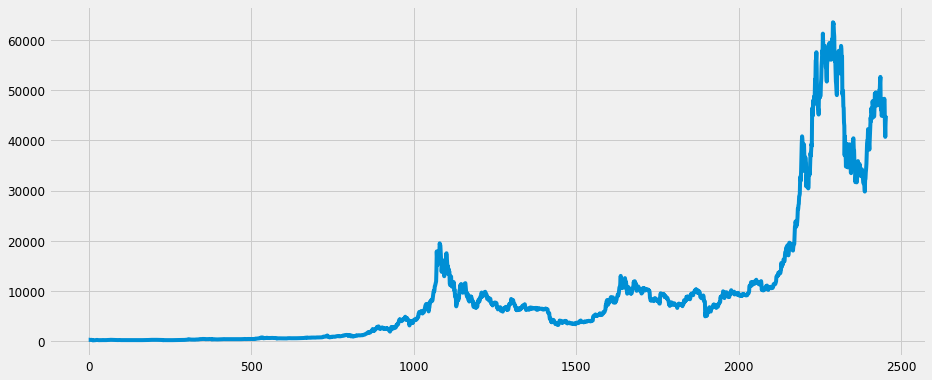

In [16]:
## testing undiff function
undif = inverse_difference(data['Close'], cox_diff)
undif
plt.plot(undif);

In [17]:
len(cox_diff)

2455

In [18]:
# Convert in df
cox_diff = pd.DataFrame(cox_diff) 

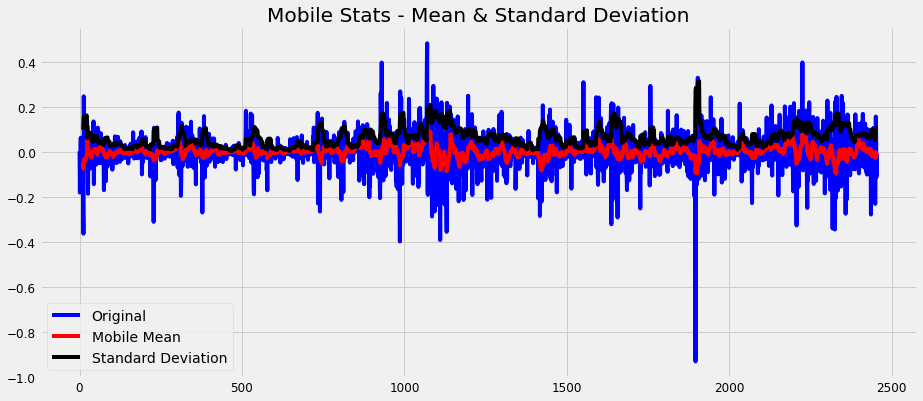


Dickey-Fuller Test Result:

Test Stats                    -1.467085e+01
p-value                        3.268538e-27
Number of Lags                 9.000000e+00
Number of Used Observations    2.445000e+03
Critic Value (1%)             -3.433027e+00
Critic Value (5%)             -2.862723e+00
Critic Value (10%)            -2.567400e+00
dtype: float64

Conclusion:

O p-value < 0.05 and, therefore, we have evidences to reject H0.
This serie probably is stationary


In [19]:
# Testing if the differentiation was enough
stationarity_test(cox_diff)

In [20]:
# Remove NA values generated
cox_diff.dropna(inplace=True)

In [21]:
x = pd.Series([0])
cox_diff = pd.concat([x, cox_diff])
data.reset_index()

data = data.reset_index()
cox_diff = cox_diff.set_index(data['Date'])
data = data.set_index('Date')

In [22]:
data['cox_diff'] = cox_diff

## Function to evaluate performance of the model

In [23]:
# Accuracy of the model
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE of predictions is {}'.format(round(mse, 2))+
                  '\nRMSE of predictions is {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE of predictions is {}'.format(round(mape, 2))))

## Split Train and Test

In [24]:
# Split test and train
X = data
train_size = int(len(X) * 0.80)
trainset, testset = X[0:train_size], X[train_size:]

In [25]:
target = trainset['cox_diff']

## Naive Bayes

In [26]:
# Create an array with target var values of trainset
array_count_train = np.asarray(target)
array_count_train

array([ 0.        ,  0.00392623, -0.17910569, ...,  0.01077543,
        0.06376519,  0.0119194 ])

In [27]:
# Copy of validation data
df_valid_cp = testset.copy()
df_valid_cp.head()

,Open,High,Low,Close,Adj Close,Volume,Close_Box,cox_diff
Date,,,,,,,,
2020-05-19,9727.063477,9836.047852,9539.624023,9729.038086,9729.038086,39254288955,13.508461,0.000524
2020-05-20,9725.329102,9804.793945,9447.201172,9522.981445,9522.981445,36546239703,13.464167,-0.044294
2020-05-21,9522.740234,9555.242188,8869.930664,9081.761719,9081.761719,39326160532,13.366274,-0.097892
2020-05-22,9080.334961,9232.936523,9008.638672,9182.577148,9182.577148,29810773699,13.389022,0.022748
2020-05-23,9185.062500,9302.501953,9118.108398,9209.287109,9209.287109,27727866812,13.395010,0.005988


In [28]:
# Predictions
df_valid_cp['naive_prediction'] = array_count_train[len(array_count_train) - 1] 

In [29]:
# Real and Predicted Value
df_valid_cp[['cox_diff', 'naive_prediction']].head()

,cox_diff,naive_prediction
Date,,
2020-05-19,0.000524,0.011919
2020-05-20,-0.044294,0.011919
2020-05-21,-0.097892,0.011919
2020-05-22,0.022748,0.011919
2020-05-23,0.005988,0.011919


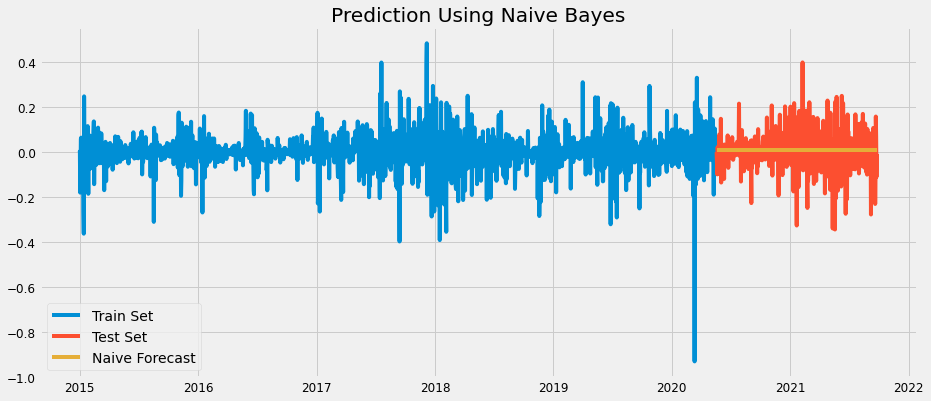

In [30]:
# Plot
plt.title("Prediction Using Naive Bayes") 
plt.plot(trainset.index, trainset['cox_diff'], label = 'Train Set') 
plt.plot(testset.index, testset['cox_diff'], label = 'Test Set') 
plt.plot(df_valid_cp.index, df_valid_cp['naive_prediction'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

## ARIMA

In [31]:
# Model
model_AR = ARIMA(target, order = (2, 1, 0))

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [32]:
# Fitting
model_arima_fit = model_AR.fit() 

In [33]:
# Real Data and Predictions
real_data = target
pred = model_arima_fit.fittedvalues

Plot of predictions and original serie considering transformed values.

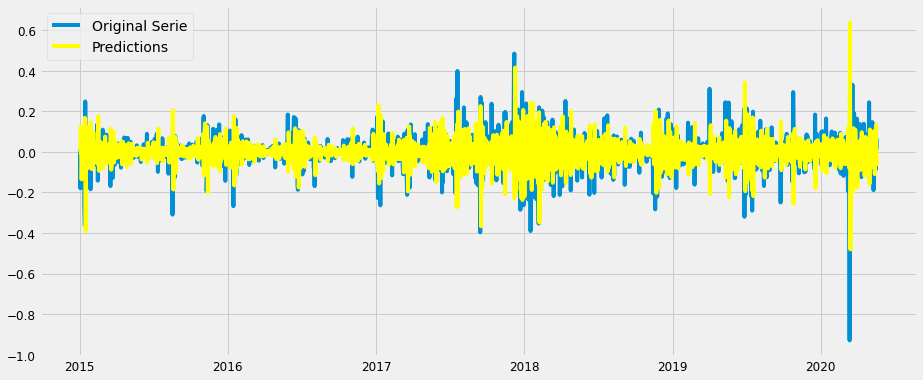

In [34]:
# Plot
plt.plot(real_data, label = 'Original Serie') 
plt.plot(pred, color = 'yellow', label = 'Predictions') 
plt.legend(loc = 'best') 
plt.show()

In [35]:
# Summary
model_arima_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -3923.3182
Dependent Variable: D.cox_diff       Log-Likelihood:      1976.8    
Date:               2021-09-26 21:53 Scale:               1.0000    
No. Observations:   1963             Method:              css-mle   
Df Model:           3                Sample:              1         
Df Residuals:       1960                                  4         
Converged:          1.0000           S.D. of innovations: 0.088     
No. Iterations:     14.0000          HQIC:                -3937.441 
AIC:                -3945.6471                                      
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                0.0000   0.0010   0.0299 0.9761 -0.0019  0.0020
ar.L1.D.cox_diff    -0.6892   0.0213 -32.4281 0.0000 -0.7308 -0.6475
ar.L2.D.cox_diff    -0.3367   0.0213 -15.8388 0.0000 -0.3784 -0.2951
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.0233            -1.3866           1.7233            -0.3512
AR.2           -1.0233             1.3866           1.7233             0.3512
====================================================================

"""

In [36]:
# Forecast - alpha is the interval of confidence - 95%
fc, se, conf = model_arima_fit.forecast(len(testset), alpha = 0.05) 

In [37]:
# Dataframe to plot
fc_series = pd.Series(fc, index = testset.index)
lower_limit = pd.Series(conf[:, 0], index = testset.index)
upper_limit = pd.Series(conf[:, 1], index = testset.index)

Getting real values back to plot the graphic and compare predictions.

In [38]:
# Getting real values to forecast
forecast = inverse_difference(testset['Close_Box'], fc_series)
forecast = inv_boxcox(forecast, lmbda)
forecast = pd.DataFrame(forecast)
forecast = pd.concat([x, forecast])
forecast.reset_index()
forecast = forecast.set_index(testset.index)

# Getting real values to lower limit
lower = inverse_difference(testset['Close_Box'], lower_limit)
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(testset['Close_Box'], upper_limit)
upper = inv_boxcox(upper, lmbda)

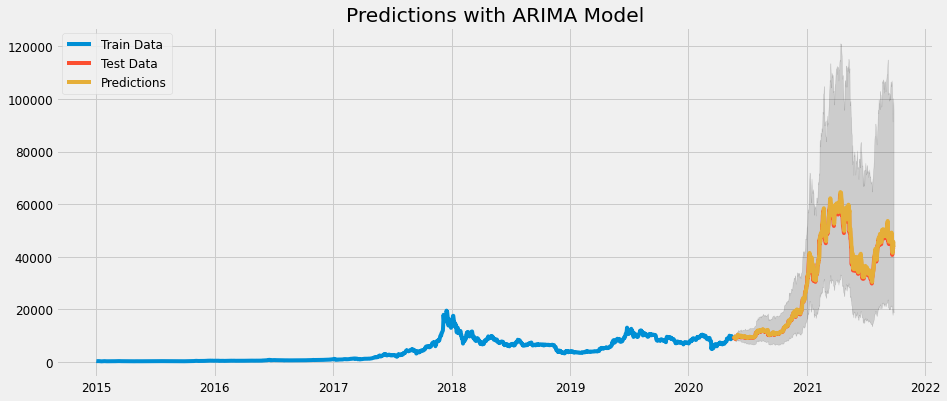

In [39]:
# Plot
plt.plot(trainset['Close'], label = 'Train Data')
plt.plot(testset['Close'], label = 'Test Data')
plt.plot(forecast[1:], label = 'Predictions')
plt.fill_between(lower_limit.index[1:], lower, upper, color = 'k', alpha = .15)
plt.title('Predictions with ARIMA Model')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

## ARIMA Model Performance

In [40]:
# Performance
arima_results = performance(testset['Close'].values, forecast.values)
arima_results

MSE of predictions is 620582275.55
RMSE of predictions is 24911.49
MAPE of predictions is 101.98


## SARIMA - Seasonal Arima

Grid Search to search best parameters to adjust the model.

In [44]:
# Grid Search to find the best model
model_sarima = pm.auto_arima(trainset['cox_diff'],
                          seasonal = True, 
                          m = 12,
                          d = 0,
                          D = 1,
                          max_p = 2, 
                          max_q = 2,
                          trace = True,
                          error_action = 'ignore',
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=17.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-3133.400, Time=0.61 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-3670.886, Time=3.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-3135.394, Time=0.26 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-3131.673, Time=0.44 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-3883.325, Time=13.98 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=35.54 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-3884.815, Time=10.93 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-3672.840, Time=2.34 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=28.17 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.30 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-3883.314, Time=13.06 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept 

In [55]:
# Summary
print(model_sarima.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                 1964
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                1946.385
Date:                  Sun, 26 Sep 2021   AIC                          -3886.770
Time:                          22:08:10   BIC                          -3870.040
Sample:                               0   HQIC                         -3880.619
                                 - 1964                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6545      0.012    -54.320      0.000      -0.678      -0.631
ar.S.L24      -0.3268      0.014    -24.151      0.000      -0.353      -0.300
sigma2         0.0079      0.000    

In [61]:
# Create the model
model_sarima_v1 = sm.tsa.statespace.SARIMAX(data['cox_diff'],
                                             order = (0, 0, 0),
                                             seasonal_order = (2, 1, 0, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [62]:
# Train the Model
model_sarima_v1_fit = model_sarima_v1.fit()

In [63]:
# Summary
print(model_sarima_v1_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                 cox_diff   No. Observations:                 2456
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                2365.214
Date:                  Sun, 26 Sep 2021   AIC                          -4724.428
Time:                          22:11:59   BIC                          -4707.053
Sample:                               0   HQIC                         -4718.110
                                 - 2456                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6604      0.012    -56.895      0.000      -0.683      -0.638
ar.S.L24      -0.3014      0.013    -22.932      0.000      -0.327      -0.276
sigma2         0.0083      0.000    

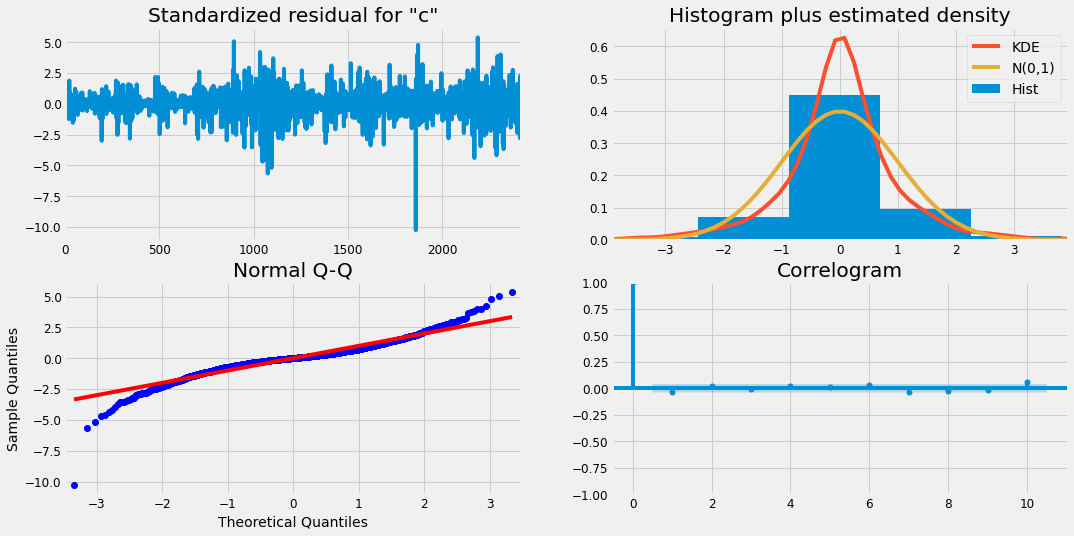

In [64]:
# Model stats
model_sarima_v1_fit.plot_diagnostics(figsize = (16, 8))
plt.show()

In [66]:
# Predictions
sarima_predict_1 = model_sarima_v1_fit.get_prediction(start = pd.to_datetime('2020-05-20'), 
                                                       end = pd.to_datetime('2021-09-25'),
                                                       dynamic = False)

In [67]:
# Confidence Interval
sarima_predict_conf_1 = sarima_predict_1.conf_int()
sarima_predict_conf_1

,lower cox_diff,upper cox_diff
Date,,
2020-05-20,-0.186776,0.170151
2020-05-21,-0.185772,0.171154
2020-05-22,-0.259328,0.097598
2020-05-23,-0.060977,0.295949
2020-05-24,-0.162321,0.194605
...,...,...
2021-09-21,-0.191830,0.165097
2021-09-22,-0.226332,0.130594
2021-09-23,-0.202441,0.154485


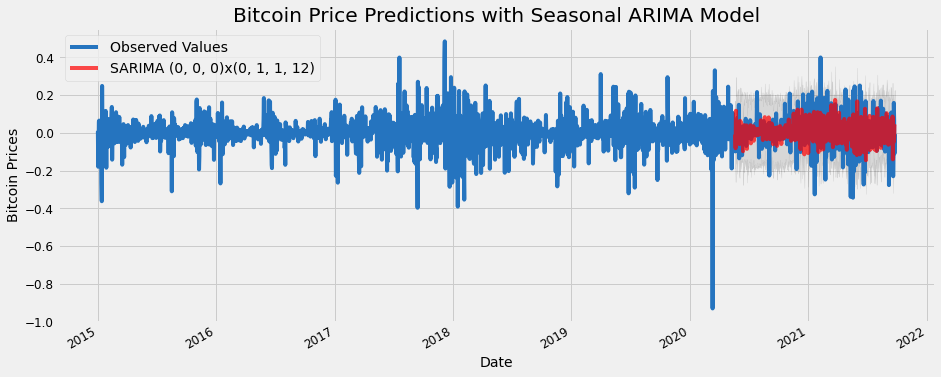

In [68]:
# Plot of observed values
ax = data.cox_diff.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
sarima_predict_1.predicted_mean.plot(ax = ax, 
                                     label = 'SARIMA (0, 0, 0)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Confidence Interval
ax.fill_between(sarima_predict_conf_1.index,
                # lower limit
                sarima_predict_conf_1.iloc[:, 0],
                # upper limit
                sarima_predict_conf_1.iloc[:, 1], color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Seasonal ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()

In [81]:
# getting real values
sarima_pred = inverse_difference(testset['Close_Box'], sarima_predict_1.predicted_mean)
sarima_pred = inv_boxcox(sarima_pred, lmbda)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred = pd.concat([x, sarima_pred])
sarima_pred.reset_index()
sarima_pred = sarima_pred.set_index(testset[:-1].index)

# Getting real values to lower limit
lower = inverse_difference(testset['Close_Box'], sarima_predict_conf_1.iloc[:, 0])
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(testset['Close_Box'], sarima_predict_conf_1.iloc[:, 1])
upper = inv_boxcox(upper, lmbda)

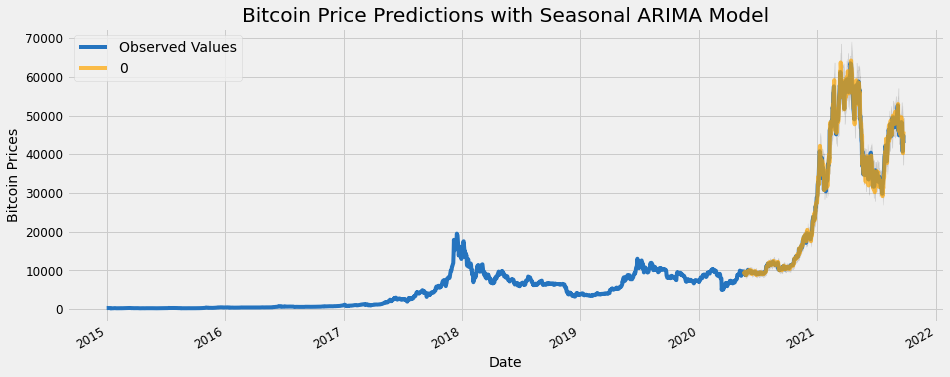

In [82]:
# Plot real values
# Plot of observed values
ax = data.Close.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
sarima_pred[1:].plot(ax = ax, label = 'SARIMA', alpha = 0.7,
                 color = 'orange') 

# Confidence Interval
ax.fill_between(sarima_predict_conf_1.index[1:],
                # lower limit
                lower,
                # upper limit
                upper, color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Seasonal ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()

## SARIMA Performance

In [83]:
# Performance
arima_results = performance(testset['Close'].values, sarima_pred.values)
arima_results

MSE of predictions is 613773622.64
RMSE of predictions is 24774.46
MAPE of predictions is 100.67


## Prophet

In [84]:
# Create model with Anual Seasonality
model_prophet = Prophet(yearly_seasonality = True)

In [85]:
# Add Built-in Country Holiday
model_prophet.add_country_holidays(country_name = 'US')

In [86]:
# format target dataset
t = data.cox_diff.reset_index()
t = t.rename(columns = {'Date': 'ds', 'cox_diff': 'y'})

In [88]:
# Train model
model_prophet.fit(t) 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
# Dataset for predictions
dataset_pred = model_prophet.make_future_dataframe(periods = 365, freq = 'd')
dataset_pred.count()

ds    2821
dtype: int64

In [90]:
# Forecast
forecast_model_prophet = model_prophet.predict(dataset_pred)

In [91]:
# Predictions
forecast_model_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2816,2022-09-21,-0.002164,-0.105697,0.097913
2817,2022-09-22,-0.002934,-0.104212,0.096608
2818,2022-09-23,0.001945,-0.091646,0.102099
2819,2022-09-24,0.001020,-0.096698,0.106742
2820,2022-09-25,-0.005384,-0.101147,0.091353


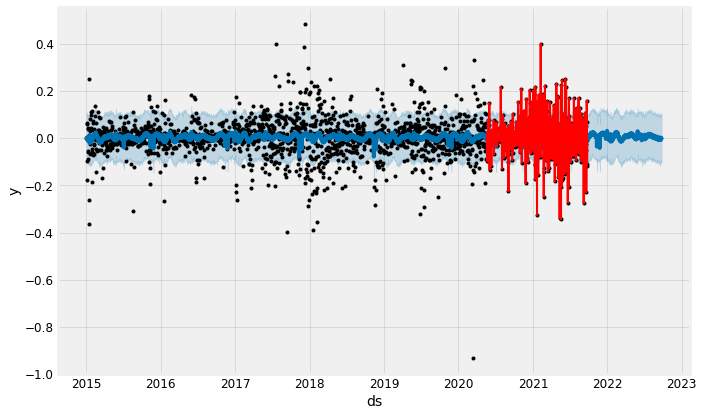

In [92]:
# Plot Predictions
fig = model_prophet.plot(forecast_model_prophet)

# Testset red
plt.plot(testset['cox_diff'], label = 'Test', color = 'red', linewidth = 2)
plt.show()

In [93]:
# Predictions
forecast_model_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Juneteenth National Independence Day,Juneteenth National Independence Day_lower,Juneteenth National Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,0.002011,-0.085663,0.107602,0.002011,0.002011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00566,0.00566,0.00566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005661,0.005661,0.005661,0.00566,0.00566,0.00566,-0.001183,-0.001183,-0.001183,0.001184,0.001184,0.001184,0.0,0.0,0.0,0.007672
1,2015-01-02,0.002015,-0.091205,0.109370,0.002015,0.002015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003383,0.003383,0.003383,0.00000,0.00000,0.00000,0.003288,0.003288,0.003288,0.000095,0.000095,0.000095,0.0,0.0,0.0,0.005398
2,2015-01-03,0.002019,-0.093049,0.106619,0.002019,0.002019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000848,0.000848,0.000848,0.00000,0.00000,0.00000,0.001888,0.001888,0.001888,-0.001040,-0.001040,-0.001040,0.0,0.0,0.0,0.002867
3,2015-01-04,0.002023,-0.102849,0.090437,0.002023,0.002023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007274,-0.007274,-0.007274,0.00000,0.00000,0.00000,-0.005058,-0.005058,-0.005058,-0.002216,-0.002216,-0.002216,0.0,0.0,0.0,-0.005251
4,2015-01-05,0.002027,-0.100445,0.103731,0.002027,0.002027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001633,0.001633,0.001633,0.00000,0.00000,0.00000,0.005061,0.005061,0.005061,-0.003428,-0.003428,-0.003428,0.0,0.0,0.0,0.003661


In [94]:
# Clean zeros
forecast_model_prophet.drop(columns = ['multiplicative_terms', 
                                        'multiplicative_terms_lower',
                                        'multiplicative_terms_upper'], inplace = True)

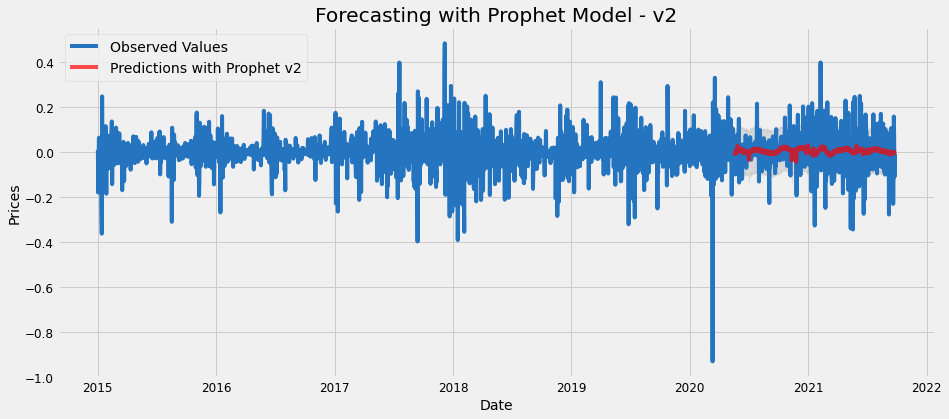

In [102]:
# Plot

# Original Serie
plt.plot(data.cox_diff.index, 
         data.cox_diff.values,
         label = 'Observed Values',
         color = '#2574BF')

i1 = len(forecast_model_prophet)-len(testset)
# Predictions
plt.plot(testset.cox_diff.index, 
         forecast_model_prophet[i1:]['yhat'].values,
         label = 'Predictions with Prophet v2', 
         alpha = 0.7, 
         color = 'red')

# Confidence Limits
plt.fill_between(testset.cox_diff.index,
                 forecast_model_prophet[i1:]['yhat_lower'].values,
                 forecast_model_prophet[i1:]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Forecasting with Prophet Model - v2')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [103]:
forecast_model_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Juneteenth National Independence Day,Juneteenth National Independence Day_lower,Juneteenth National Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2015-01-01,0.002011,-0.085663,0.107602,0.002011,0.002011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00566,0.00566,0.00566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005661,0.005661,0.005661,0.00566,0.00566,0.00566,-0.001183,-0.001183,-0.001183,0.001184,0.001184,0.001184,0.007672
1,2015-01-02,0.002015,-0.091205,0.109370,0.002015,0.002015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003383,0.003383,0.003383,0.00000,0.00000,0.00000,0.003288,0.003288,0.003288,0.000095,0.000095,0.000095,0.005398
2,2015-01-03,0.002019,-0.093049,0.106619,0.002019,0.002019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000848,0.000848,0.000848,0.00000,0.00000,0.00000,0.001888,0.001888,0.001888,-0.001040,-0.001040,-0.001040,0.002867
3,2015-01-04,0.002023,-0.102849,0.090437,0.002023,0.002023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007274,-0.007274,-0.007274,0.00000,0.00000,0.00000,-0.005058,-0.005058,-0.005058,-0.002216,-0.002216,-0.002216,-0.005251
4,2015-01-05,0.002027,-0.100445,0.103731,0.002027,0.002027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001633,0.001633,0.001633,0.00000,0.00000,0.00000,0.005061,0.005061,0.005061,-0.003428,-0.003428,-0.003428,0.003661


In [106]:
# Performance
prophet_results = performance(testset.cox_diff.values, forecast_model_prophet[i1:]['yhat'])
prophet_results

MSE of predictions is 0.01
RMSE of predictions is 0.09
MAPE of predictions is 185.04


In [108]:
# Dataset to predictions - freq by day
dataset_pred = model_prophet.make_future_dataframe(periods = 365, freq = 'd')

In [109]:
# Forecast
forecast_model_prophet_60 = model_prophet.predict(dataset_pred)

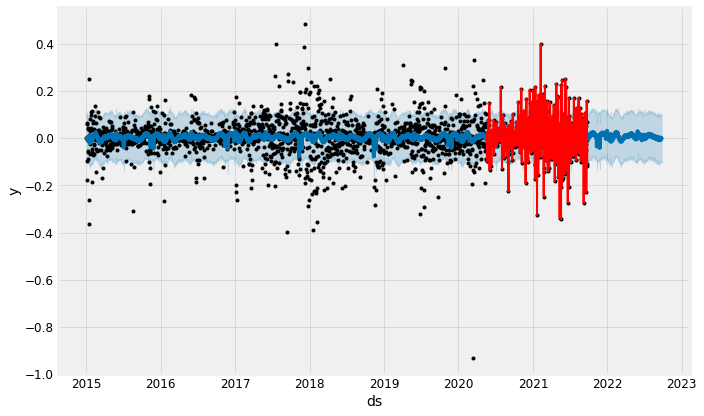

In [110]:
# Plot Predictions
fig = model_prophet.plot(forecast_model_prophet_60)

# Testset red
plt.plot(testset['cox_diff'], label = 'Teste', color = 'red', linewidth = 2)
plt.show()

In [119]:
# getting real values
i2 = len(data['Close_Box'])
prophet_pred = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat)
prophet_pred = inv_boxcox(prophet_pred, lmbda)
prophet_pred = pd.DataFrame(prophet_pred)
prophet_pred = pd.concat([x, prophet_pred])
prophet_pred = prophet_pred.reset_index()
prophet_pred = prophet_pred.set_index(data.index)

# Getting real values to lower limit
lower = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat_lower)
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat_upper)
upper = inv_boxcox(upper, lmbda)

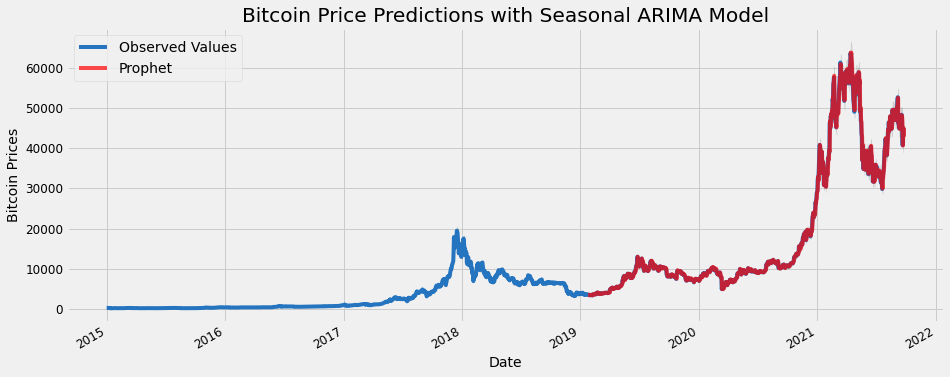

In [120]:
# Plot real values
# Plot of observed values
ax = data.Close.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
prophet_pred[1485:][0].plot(ax = ax, label = 'Prophet', alpha = 0.7,
                 color = 'red') 

# Confidence Interval
ax.fill_between(prophet_pred.index[1:],
                # lower limit
                lower,
                # upper limit
                upper, color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Seasonal ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()